In [1]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(dashboard_address=':8788')
client = Client(cluster)
client.restart()

Client Scheduler: tcp://127.0.0.1:41761 Dashboard: http://127.0.0.1:8788/status,Cluster Workers: 6 Cores: 24 Memory: 125.60 GiB


In [2]:
import dask.dataframe as dd
import numpy as np
import pandas as pd
import lightgbm as lgb
import gc

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

In [4]:
column_load_types = {'f01_num_hashtags': np.uint8, 'f02_AUTH_verified': 'category', 'f03_READ_verified': 'category',
                    'f04_auth_follows_read': 'category', 'f05_bert_length': np.uint16, 'f06_num_media': np.uint8,
                    'f07_num_domains': np.uint8, 'f08_ratio1': np.float32, 'f09_ratio2': np.float32, 
                    'f10_ratio3': np.float32, 'f11_ratio4': np.float32, 'f12_photo': np.uint8, 'f13_video': np.uint8,
                    'f14_GIF': np.uint8, 'f15_type': 'category', 'f16_hour': 'category', 'f17_num_links': np.uint8,
                    'f18_language': 'category', 'f19_weekday': 'category', 'f20_auth_creat_year': np.uint16, 
                    'f21_read_creat_year': np.uint16, 'f22_diff_creat_year':np.uint16}

In [5]:
column_type = {
    'bert': str, 'hashtags': str, 'tweet_id': str, 'media': str, 'links': str, 'domains': str, 'type': str, 'language': str, 'timestamp': np.uint32,
    'AUTH_user_id':str,'AUTH_follower_count':np.uint32,'AUTH_following_count':np.uint32,'AUTH_verified':bool,'AUTH_account_creation':np.uint32,
    'READ_user_id': str,'READ_follower_count':np.uint32,'READ_following_count':np.uint32,'READ_verified':bool,'READ_account_creation':np.uint32,
    'auth_follows_read': bool,
    'reply_timestamp':np.float32,'retweet_timestamp':np.float32,'quote_timestamp':np.float32,'like_timestamp':np.float32
}

In [6]:
from sklearn.metrics import log_loss, precision_recall_curve, auc


def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive / float(len(gt))
    return ctr


def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy / strawman_cross_entropy) * 100.0


def compute_prauc_lgb(pred, g):
    gt = np.array(g.get_label())
    pred = np.array(pred)
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return 'prauc', prauc, True


def compute_rce_lgb(pred, g):
    gt = np.array(g.get_label())
    pred = np.array(pred)
    rce = compute_rce(pred, gt)
    return 'rce',rce,True


def focal_loss_lgb(y_pred, dtrain, alpha, gamma):
    a, g = alpha, gamma
    y_true = dtrain.label
    
    def fl(x,t):
        p = 1 / (1 + np.exp(-x))
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
    
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return grad, hess


def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma):
    a, g = alpha, gamma
    y_true = dtrain.label
    p = 1 / (1 + np.exp(-y_pred))
    loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
    return 'focal_loss', np.mean(loss), False

In [8]:
def basic_features(df):

    df['f01_num_hashtags'] = df.hashtags.str.split('\t').str.len().fillna(0).astype(np.uint8)
    df['f02_AUTH_verified'] = df.AUTH_verified.astype(int).astype('category')
    df['f03_READ_verified'] = df.READ_verified.astype(int).astype('category')
    df['f04_auth_follows_read'] = df.auth_follows_read.astype(int).astype('category')
    df['f05_bert_length'] = df.bert.str.split('\t').str.len().fillna(0).astype(np.uint16)
    #df = df.drop(columns=['bert'])
    df['f06_num_media'] = df.media.str.split('\t').str.len().fillna(0).astype(np.uint8)
    df['f07_num_domains'] = df.domains.str.split('\t').str.len().fillna(0).astype(np.uint8)
    df['f08_ratio1'] = df.AUTH_following_count/(df.READ_following_count+1e-6).astype(np.float32)
    df['f09_ratio2'] = df.AUTH_following_count/(df.READ_follower_count+1e-6).astype(np.float32)
    df['f10_ratio3'] = df.READ_following_count/(df.READ_follower_count+1e-6).astype(np.float32)
    df['f11_ratio4'] = df.AUTH_follower_count/(df.READ_follower_count+1e-6).astype(np.float32)
    df['f12_photo'] = df.media.str.count('Photo').fillna(0).astype(np.uint8)
    df['f13_video'] = df.media.str.count('Video').fillna(0).astype(np.uint8)
    df['f14_GIF'] = df.media.str.count('GIF').fillna(0).astype(np.uint8)
    df['f15_type'] = df.type.astype('category')
    df['f16_hour'] = df.timestamp.astype('M8[s]').dt.hour.astype('category')
    df['f17_num_links'] = df.links.str.split('\t').str.len().fillna(0).astype(np.uint8)

    dct_langs = {row['language']: i for i, row in pd.read_csv('/data/recsys/stats/language_counts.csv').iterrows() }
    df['f18_language'] = df.language.replace(dct_langs).astype('category')
    df['f19_weekday'] = df.timestamp.astype('M8[s]').dt.weekday.astype('category')
    df['f20_auth_creat_year'] = df.AUTH_account_creation.astype('M8[s]').dt.year.apply(lambda x: 0 if x<0 else x, meta=(None, 'int')).astype(np.uint16)
    df['f21_read_creat_year'] = df.READ_account_creation.astype('M8[s]').dt.year.apply(lambda x: 0 if x<0 else x, meta=(None, 'int')).astype(np.uint16)
    df['f22_diff_creat_year'] = (df.AUTH_account_creation.astype('M8[s]').dt.year.apply(lambda x: 0 if x<0 else x, meta=(None, 'int')).astype(int) - df.READ_account_creation.astype('M8[s]').dt.year.apply(lambda x: 0 if x<0 else x, meta=(None, 'int'))).astype(np.int16)    
    
    df['f23_at_bert'] = df.bert.str.contains('\t137\t').astype(np.uint8).astype('category')            # At sign: @
    df['f24_rt_at_bert'] = df.bert.str.contains('\t56898\t137\t').astype(np.uint8).astype('category')  # RT at sign: RT @
    
    df['f25_unk'] = df.bert.str.count('\t100\t').astype(np.uint8)
    df['f26_unk_ratio'] = (df['f25_unk'] / df['f05_bert_length']).astype(np.float32)

    return df


def text_features(df):
    df = pd.concat([df, df.bert.str.extract(r'^\d+\t(?P<f27_tok1>\d+)?\t(?P<f28_tok2>\d+)?\t.*\t(?P<f29_tok3>\d+)?\t(?P<f30_tok4>\d+)?\t\d+$').fillna(101)], axis=1)

    df['f27_tok1'] = pd.Categorical(df['f27_tok1'].astype(int), categories=list(range(0,119548)))
    df['f28_tok2'] = pd.Categorical(df['f28_tok2'].astype(int), categories=list(range(0,119548))) 
    df['f29_tok3'] = pd.Categorical(df['f29_tok3'].astype(int), categories=list(range(0,119548))) 
    df['f30_tok4'] = pd.Categorical(df['f30_tok4'].astype(int), categories=list(range(0,119548)))
    
    df['f31_question'] = df.bert.str.count('\t136\t').astype(np.uint8)
    return df


def merge_popularity(df):
    # AUTH popularity
    auth_merge = pd.read_csv('/data/recsys/auth_pop_tweet/auth_merge_div_counts.csv',
                             dtype={'reply': np.float32, 'retweet': np.float32, 
                                    'quote': np.float32, 'like': np.float32})
    auth_merge = auth_merge.rename(columns={'reply': 'avg_reply', 'retweet': 'avg_retweet', 
                                             'quote': 'avg_quote', 'like': 'avg_like'})
    df = df.reset_index(drop=True)

    _cols = ['avg_reply', 'avg_retweet', 'avg_quote', 'avg_like', 'AUTH_count_user_id']
    df[_cols] = pd.merge(df[['AUTH_user_id']], auth_merge, on='AUTH_user_id', how='left').fillna(0)[_cols]

    del auth_merge

    print('Auth done')

    # READ popularity
    read_merge = pd.read_csv('/data/recsys/read_pop/read_merge_div_counts.csv',
                             dtype={'reply': np.float32, 'retweet': np.float32, 
                                    'quote': np.float32, 'like': np.float32})
    read_merge = read_merge.rename(columns={'reply': 'avg_reply_read', 'retweet': 'avg_retweet_read', 
                                             'quote': 'avg_quote_read', 'like': 'avg_like_read'})
    df = df.reset_index(drop=True)
    _cols = ['avg_reply_read', 'avg_retweet_read', 'avg_quote_read', 'avg_like_read', 'READ_count_user_id']
    df[_cols] = pd.merge(df[['READ_user_id']], read_merge, on='READ_user_id', how='left').fillna(0)[_cols]
    
    del read_merge, _cols
    
    print('Read done')

    return df


def merge_type_pop(df):

    auth_merge = pd.read_csv('/data/recsys/tef_auth_tt/auth_tt_merge_div.csv').rename(columns = {'is_cT':'is_aT', 'is_cR':'is_aR', 'is_cQ':'is_aQ'})
    df = df.reset_index(drop=True)
    _cols = ['rep_aT', 'ret_aT', 'quo_aT', 'lik_aT', 'rep_aR', 'ret_aR', 'quo_aR', 'lik_aR', 'rep_aQ', 'ret_aQ', 'quo_aQ', 'lik_aQ', 'is_aT', 'is_aR', 'is_aQ']
    df[_cols] = pd.merge(df[['AUTH_user_id']], auth_merge, on='AUTH_user_id', how='left').fillna(0)[_cols]
    del auth_merge, _cols
    print("Auth type done")

    read_merge = pd.read_csv('/data/recsys/tef_read_tt/read_tt_merge_div.csv').rename(columns = {'is_cT': 'is_aT', 'is_cR': 'is_aR', 'is_cQ': 'is_aQ'})
    _cols_old = ['rep_aT', 'ret_aT', 'quo_aT', 'lik_aT', 'rep_aR', 'ret_aR', 'quo_aR', 'lik_aR', 'rep_aQ', 'ret_aQ', 'quo_aQ', 'lik_aQ', 'is_aT', 'is_aR', 'is_aQ']
    _cols = [c+'_read' for c in _cols_old]
    read_merge = read_merge.rename(columns=dict(zip(_cols_old, _cols)))
    df = df.reset_index(drop=True)
    df[_cols] = pd.merge(df[['READ_user_id']], read_merge, on='READ_user_id', how='left').fillna(0)[_cols]
    del read_merge, _cols_old, _cols

    print('Read type done')
    return df


def smooth_pops(dfd):
    _means = json.load(open('means.json', 'r'))

    K=10

    for prob in ['avg_reply', 'avg_retweet', 'avg_quote', 'avg_like', 
            'avg_reply_read', 'avg_retweet_read', 'avg_quote_read', 'avg_like_read',
            'rep_aT', 'ret_aT', 'quo_aT', 'lik_aT', 'rep_aR', 'ret_aR', 'quo_aR', 'lik_aR', 'rep_aQ', 'ret_aQ', 'quo_aQ', 'lik_aQ',
            'rep_aT_read', 'ret_aT_read', 'quo_aT_read', 'lik_aT_read', 'rep_aR_read', 'ret_aR_read', 'quo_aR_read', 'lik_aR_read', 'rep_aQ_read', 'ret_aQ_read', 'quo_aQ_read', 'lik_aQ_read']:        
    
        if 'lik' in prob:
            mn = _means['like']
        if 'ret' in prob:
            mn = _means['retweet']
        if 'quo' in prob:
            mn = _means['quote']
        if 'rep' in prob:
            mn = _means['reply']
    
        if 'avg' in prob:
            if 'read' in prob:
                dfd[prob] = ((dfd[prob] * dfd['r_count']) + (mn * K)) / (K + dfd['r_count'])
            else:
                dfd[prob] = ((dfd[prob] * dfd['a_count']) + (mn * K)) / (K + dfd['a_count'])    
        else:
            if 'aT' in prob:
                if 'read' in prob:
                    dfd[prob] = ((dfd[prob] * dfd['is_aT_read']) + (mn * K)) / (K + dfd['is_aT_read'])
                else:
                    dfd[prob] = ((dfd[prob] * dfd['is_aT']) + (mn * K)) / (K + dfd['is_aT'])
            
            elif 'aR' in prob:
                if 'read' in prob:
                    dfd[prob] = ((dfd[prob] * dfd['is_aR_read']) + (mn * K)) / (K + dfd['is_aR_read'])
                else:
                    dfd[prob] = ((dfd[prob] * dfd['is_aR']) + (mn * K)) / (K + dfd['is_aR'])
            
            else:
                if 'read' in prob:
                    dfd[prob] = ((dfd[prob] * dfd['is_aQ_read']) + (mn * K)) / (K + dfd['is_aQ_read'])
                else:
                    dfd[prob] = ((dfd[prob] * dfd['is_aQ']) + (mn * K)) / (K + dfd['is_aQ'])

    return dfd


df = dd.read_csv('/data/recsys/valid/part-00000.1', names=list(column_type.keys()), header=None, sep='\x01', dtype=column_type)    

# Create basic features and save its names
df = basic_features(df)
features = ['AUTH_follower_count', 'AUTH_following_count', 'READ_follower_count', 'READ_following_count']
features = features + [col for col in df.columns if col[1:3] in [f'{i:02d}' for i in range(1, 100)]]

# Compute the dataset. Merges and concats with dask can bring problems
df = df.loc[:, ['bert','tweet_id', 'AUTH_user_id', 'READ_user_id','like_timestamp','retweet_timestamp','quote_timestamp','reply_timestamp']+features].compute()

# Text features
df = text_features(df)

features = ['AUTH_follower_count', 'AUTH_following_count', 'READ_follower_count', 'READ_following_count']
features = features + sorted([col for col in df.columns if col[1:3] in [f'{i:02d}' for i in range(1, 100)]])

# Compute logcounts appearances log10(appearances)
# df = merge_logcounts(df)
# features = features + ['f25_auth_log_count', 'f26_read_log_count']

print('Compute completed')

# Merge the popularity as 8 new columns
df = merge_popularity(df)
features = features + ['avg_reply', 'avg_retweet', 'avg_quote', 'avg_like']
features = features + ['avg_reply_read', 'avg_retweet_read', 'avg_quote_read', 'avg_like_read']

df = merge_type_pop(df)
tp = ['rep_aT', 'ret_aT', 'quo_aT', 'lik_aT', 'rep_aR', 'ret_aR', 'quo_aR', 'lik_aR', 'rep_aQ', 'ret_aQ', 'quo_aQ', 'lik_aQ']
features = features + tp
features = features + [t+'_read' for t in tp]


for target in ['like', 'retweet', 'reply', 'quote']:
    df[target + '_timestamp'] = (df[target + '_timestamp'] > 0).astype(np.uint8)

df['a_count'] = df['is_aT']+df['is_aR']+df['is_aQ']
df['r_count'] = df['is_aT_read'] + df['is_aR_read'] + df['is_aQ_read']
features = features + ['a_count', 'r_count']
    
import json
df = smooth_pops(df)

In [10]:
from sklearn.model_selection import train_test_split

In [ ]:
%%time

### TESTING

#27.8, 31.8, 31.1, 22.5

# Set it to True to predict the next engagements using the predictions from the previous ones
chained_prediction = False
boosters = []

for target in ['like', 'retweet', 'reply', 'quote']:
    
    df_train, df_test = train_test_split(df, stratify=df[f'{target}_timestamp'], test_size=0.2, random_state=17)
    train_data = lgb.Dataset(df_train.loc[:, features], label=df_train[f'{target}_timestamp'])
    test_data = lgb.Dataset(df_test.loc[:, features], label=df_test[f'{target}_timestamp'])
    
    _, df_train_sample = train_test_split(df_train, stratify=df_train[f'{target}_timestamp'], test_size=int(1e5), random_state=17)
    train_data_sample = lgb.Dataset(df_train_sample.loc[:, features], label=df_train_sample[f'{target}_timestamp'])
    
    # https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html#lightgbm.train
    param = {'max_depth': 10,
             'nthread': 24,
             'num_leaves': 128,
             'lambda_l1': 1,
             'lambda_l2': 1,
             'bagging_freq':1,        # Always perform bagging
             'bagging_fraction':0.66, # % of rows selected in each tree
             #'min_data_in_leaf':1000,
             #'min_gain_to_split':0.01,
             'feature_fraction':0.8,
#                  'boosting':'dart',
             'learning_rate': 0.01,
             'objective':'cross_entropy',
             'metric': 'None',   # For the null metric use 'None' instead of None:
                                 #  None  -> objective metric is considered in early stopping
                                 # 'None' -> objective is not considered
             'device': 'cpu',
             'random_state': 42,
             'is_unbalance': True}

    print(target)
    print('=' * 50)

    evals_result = {}
    alpha = 0.1
    k = -0.004
    lgb_model = lgb.train(param,
                          train_data,
                          num_boost_round=5000,
                          evals_result=evals_result,
                                                                           # function vs metric:
                                                                           # function: custom defined (callable)
                                                                           # metric: predefined string
                          feval=[compute_rce_lgb, compute_prauc_lgb],      # To use feval you must set metric to None
                          valid_sets=[train_data_sample, test_data],
#                           early_stopping_rounds=25,
                              callbacks=[
                                      # First metric only to use only RCE for early stopping
                                      # since it is the one with higher impact
                                      lgb.early_stopping(50, first_metric_only=True),
                                      lgb.reset_parameter(learning_rate=lambda current_round: max(alpha * np.exp(k * current_round), 0.01))
                              ],
                          verbose_eval=25)
    lgb_model.save_model(f'{target}_bst.lgb')
    boosters.append((lgb_model, evals_result))
    print()
    print()

    # OPTIONAL: Predicted label as feature for next
    if chained_prediction:
        df[target + '_timestamp'] = lgb_model.predict(df.loc[:, features])
        features += [target + '_timestamp']

like
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.295933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32858
[LightGBM] [Info] Number of data points in the train set: 11569408, number of used features: 69


/opt/miniconda/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/miniconda/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.400101 -> initscore = -0.405046
[LightGBM] [Info] Start training from score -0.405046
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rce: 16.7635	valid_0's prauc: 0.675071	valid_1's rce: 16.7325	valid_1's prauc: 0.673805
[50]	valid_0's rce: 18.2071	valid_0's prauc: 0.686156	valid_1's rce: 17.8815	valid_1's prauc: 0.681326
[75]	valid_0's rce: 18.8462	valid_0's prauc: 0.692101	valid_1's rce: 18.2768	valid_1's prauc: 0.684511
[100]	valid_0's rce: 19.1294	valid_0's prauc: 0.6949	valid_1's rce: 18.4202	valid_1's prauc: 0.68566
[125]	valid_0's rce: 19.2722	valid_0's prauc: 0.696258	valid_1's rce: 18.4886	valid_1's prauc: 0.686209
[150]	valid_0's rce: 19.3673	valid_0's prauc: 0.697271	valid_1's rce: 18.5273	valid_1's prauc: 0.686527
[175]	valid_0's rce: 19.4448	valid_0's prauc: 0.698034	valid_1's rce: 18.5569	valid_1's prauc: 0.686771
[200]	valid_0's rce: 19.5199	valid_0's prauc: 0.698846	valid_1's rce: 18

In [ ]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(2, 4, figsize=(20,8))
axs = axs.flatten()
for idx, title in enumerate(['like', 'retweet', 'reply', 'quote']):
    lgb.plot_metric(boosters[idx][1], 'prauc', ax=axs[idx])
    axs[idx].set_title(title+'-PRAUC')
    lgb.plot_metric(boosters[idx][1], 'rce', ax=axs[idx+4])
    axs[idx+4].set_title(title+'-RCE')
plt.tight_layout()
plt.savefig('fig_learning_curves_PPPv2.png')
plt.show()

In [ ]:
from matplotlib import pyplot as plt

# 1 vertical
# -1 horizontal
mode = 1 # -1  

_, axs = plt.subplots(2,2,figsize=(25,20))
axs = axs.flatten()
for i, target in enumerate(['like', 'retweet', 'reply', 'quote']):
    bst = lgb.Booster(model_file=target + '_bst.lgb')
    fn, im = zip(*sorted(list(zip(bst.feature_name(), bst.feature_importance('gain'))), key=lambda x: mode*x[1]))
#     print(bst.__dict__['params'])
    ax = axs[i]
    if mode == 1:
        ax.barh(fn, im)
    else:
        ax.bar(fn, im)
        ax.set_xticklabels(fn, rotation=90)
    
    ax.set_title(target);
plt.tight_layout()
plt.savefig('fig_feature_importance_PPPv2.png')
plt.show()

In [10]:
import os
os.chdir(f'/notebooks/Recsys/Recsys2021/submissions/zzz_final1')

!unzip zzz_final1.zip

Archive:  zzz_final1.zip
  inflating: auth_merge_div_counts.csv  
  inflating: auth_tt_merge_div.csv   
  inflating: language_counts.csv     
  inflating: like_bst.lgb            
  inflating: means.json              
  inflating: quote_bst.lgb           
  inflating: read_merge_div_counts.csv  
  inflating: read_tt_merge_div.csv   
  inflating: reply_bst.lgb           
  inflating: retweet_bst.lgb         
  inflating: run                     


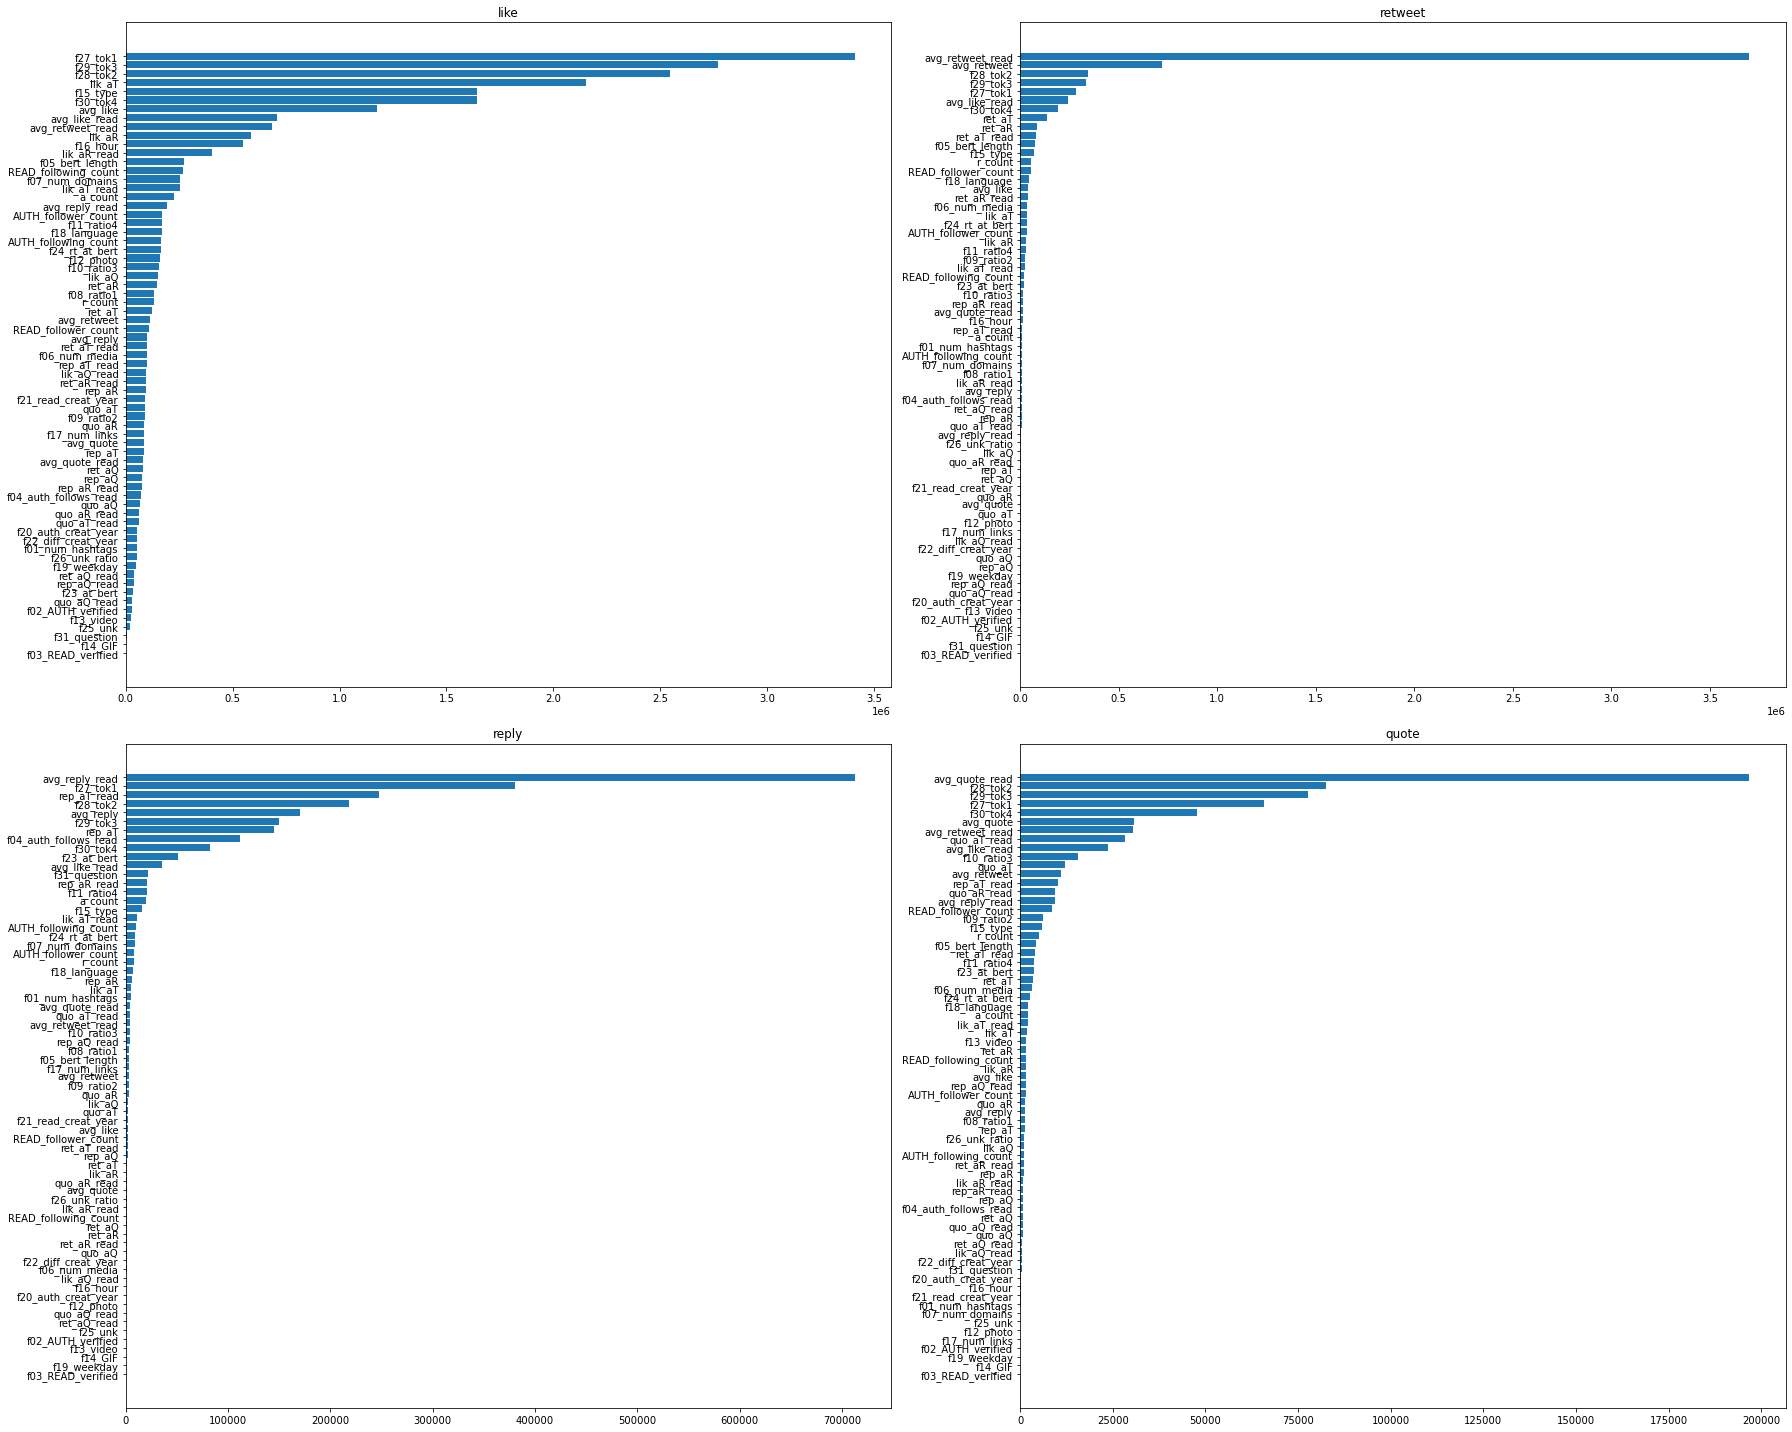

In [11]:
from matplotlib import pyplot as plt

# 1 vertical
# -1 horizontal
mode = 1 # -1  

_, axs = plt.subplots(2,2,figsize=(25,20))
axs = axs.flatten()
for i, target in enumerate(['like', 'retweet', 'reply', 'quote']):
    bst = lgb.Booster(model_file=target + '_bst.lgb')
    fn, im = zip(*sorted(list(zip(bst.feature_name(), bst.feature_importance('gain'))), key=lambda x: mode*x[1]))
#     print(bst.__dict__['params'])
    ax = axs[i]
    if mode == 1:
        ax.barh(fn, im)
    else:
        ax.bar(fn, im)
        ax.set_xticklabels(fn, rotation=90)
    ax.set_title(target);
plt.tight_layout()
plt.show()

In [18]:
# # Copy all the necessary files into the RecsysDocker

# !cp *.lgb /data/recsys/RecsysDocker/
# !cp /data/recsys/auth_pop_tweet/auth_merge_div_counts.csv /data/recsys/RecsysDocker/
# !cp /data/recsys/tef_read_tt/read_tt_merge_div.csv /data/recsys/RecsysDocker/
# !cp /data/recsys/tef_auth_tt/auth_tt_merge_div.csv /data/recsys/RecsysDocker/
# !cp /data/recsys/read_pop/read_merge_div_counts.csv /data/recsys/RecsysDocker/
# !cp means.json /data/recsys/RecsysDocker/